In [66]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
#from evaluation_functions import ensemble_evaluation_functions as eef
#import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
#from calibration_functions import huxt_rank_functions as hrf

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number

# ensemble functions
import huxt_ensemble_functions as hef 

In [67]:
def ICMElist(filepath = None):
    # -*- coding: utf-8 -*-
    """
    A script to read and process Ian Richardson's ICME list.

    Some pre-processing is required:
        Download the following webpage as a html file: 
            http://www.srl.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm
        Open in Excel, remove the year rows, delete last column (S) which is empty
        Cut out the data table only (delete header and footer)
        Save as a CSV.

    """
    
    if filepath is None:
        datapath =  system._setup_dirs_()['datapath']
        filepath = os.path.join(datapath,
                                'Richardson_Cane_Porcessed_ICME_list.csv')
    
    
    icmes=pd.read_csv(filepath,header=None)
    #delete the first row
    icmes.drop(icmes.index[0], inplace=True)
    icmes.index = range(len(icmes))
    
    for rownum in range(0,len(icmes)):
        for colnum in range(0,3):
            #convert the three date stamps
            datestr=icmes[colnum][rownum]
            year=int(datestr[:4])
            month=int(datestr[5:7])
            day=int(datestr[8:10])
            hour=int(datestr[11:13])
            minute=int(datestr[13:15])
            #icmes.set_value(rownum,colnum,datetime(year,month, day,hour,minute,0))
            icmes.at[rownum,colnum] = datetime.datetime(year,month, day,hour,minute,0)
            
        #tidy up the plasma properties
        for paramno in range(10,17):
            dv=str(icmes[paramno][rownum])
            if dv == '...' or dv == 'dg' or dv == 'nan':
                #icmes.set_value(rownum,paramno,np.nan)
                icmes.at[rownum,paramno] = np.nan
            else:
                #remove any remaining non-numeric characters
                dv=re.sub('[^0-9]','', dv)
                #icmes.set_value(rownum,paramno,float(dv))
                icmes.at[rownum,paramno] = float(dv)
        
    
    #chage teh column headings
    icmes=icmes.rename(columns = {0:'Shock_time',
                                  1:'ICME_start',
                                  2:'ICME_end',
                                  10:'dV',
                                  11: 'V_mean',
                                  12:'V_max',
                                  13:'Bmag',
                                  14:'MCflag',
                                  15:'Dst',
                                  16:'V_transit'})
    return icmes

In [96]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

## Create verificaton dataset with ICMEs removed from the timeseries
df_ICME = ICMElist("C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_Calibration\\data\\Richardson_Cane_Porcessed_ICME_list.csv")
df_ICME = df_ICME.set_index('Shock_time')

# Create a list of ICME (start,end) times 
CME_flags = [*zip(df_ICME.loc['2023']['ICME_start'], df_ICME.loc['2023']['ICME_end'])]

# Loop through ICME timing list and remove observations within CME start/end crossing period.
df_temp = omni_data.copy()
for start_time, end_time in CME_flags:

    # Replace values with NaN for rows within the specified time period
    df_temp.loc[(df_temp.index >= start_time) & (df_temp.index <= end_time)] = np.nan

    # Remove from time_series 
    #df_filtered = df_temp[~((df_temp.index >= start_time) & (df_temp.index <= end_time))]
    #df_temp = df_filtered.copy()

df_filtered = df_temp.copy()  

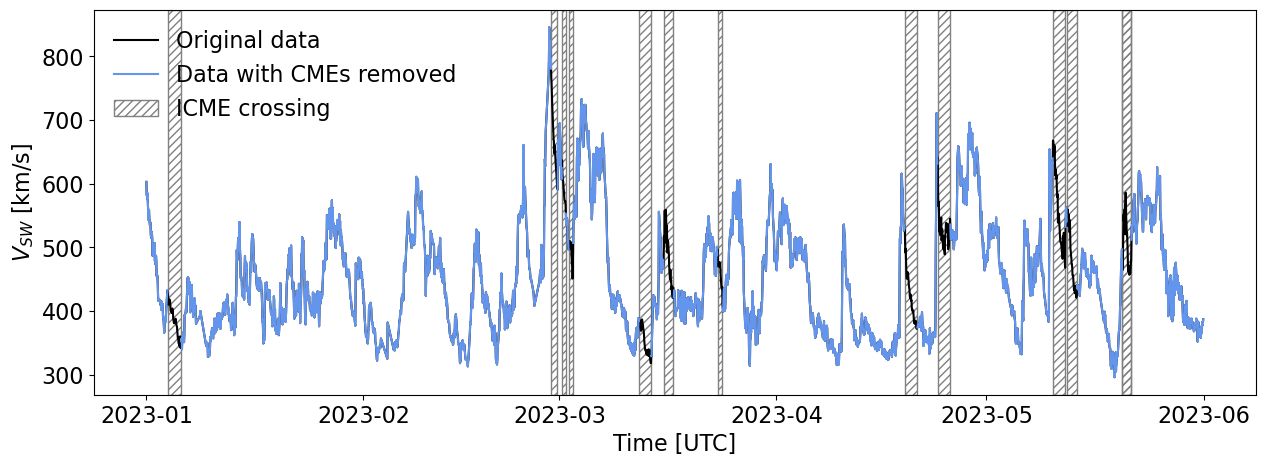

In [127]:
plt.figure(figsize = (15,5))
plt.plot(omni_data.loc['2023-01':'2023-05']['V'], label = 'Original data', color = 'black')
plt.plot(df_filtered.loc['2023-01':'2023-05']['V'], label = 'Data with CMEs removed', color = 'cornflowerblue')

for start_time, end_time in CME_flags:
    plt.axvspan(start_time, end_time, fill = None , color = 'grey', hatch = '////')

plt.axvspan(start_time, end_time, fill = None , color = 'grey', hatch = '////', label = 'ICME crossing')
plt.xlabel('Time [UTC]')
plt.ylabel(r'$V_{SW}$ [km/s]')
plt.legend(frameon = False)
plt.show()

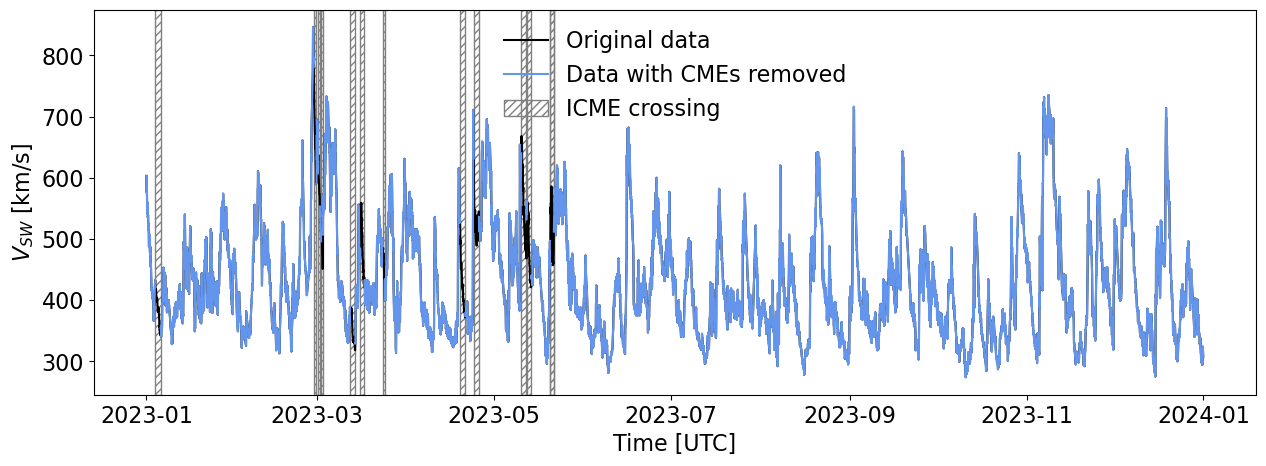

In [128]:
plt.figure(figsize = (15,5))
plt.plot(omni_data.loc['2023']['V'], label = 'Original data', color = 'black')
plt.plot(df_filtered.loc['2023']['V'], label = 'Data with CMEs removed', color = 'cornflowerblue')

for start_time, end_time in CME_flags:
    plt.axvspan(start_time, end_time, fill = None , color = 'grey', hatch = '////')

plt.axvspan(start_time, end_time, fill = None , color = 'grey', hatch = '////', label = 'ICME crossing')
plt.xlabel('Time [UTC]')
plt.ylabel(r'$V_{SW}$ [km/s]')
plt.legend(frameon = False)
plt.show()

In [4]:
def compute_lead_time_stats(df):

    df_ = df.copy()
    
    # Calculating the statistics
    df_['mean'] = df_.mean(axis=1)
    df_['median'] = df_.median(axis=1)
    df_['min'] = df_.min(axis=1)
    df_['max'] = df_.max(axis=1)
    df_['lower_1_sigma'] = df_.apply(lambda row: np.percentile(row, 15.87), axis=1)
    df_['upper_1_sigma'] = df_.apply(lambda row: np.percentile(row, 84.13), axis=1)
    df_['lower_2_sigma'] = df_.apply(lambda row: np.percentile(row, 2.28), axis=1)
    df_['upper_2_sigma'] = df_.apply(lambda row: np.percentile(row, 97.72), axis=1)

    return df_

In [10]:
sigma_latitude = 10
ensemble_size = 100
# get all WSA files with specified keywords
directory_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
ensemble_file_words = [f'ens_{int(sigma_latitude)}_{ensemble_size}'] # keywords to filter for in coronal model file directory
ensemble_fname = hef.get_files_containing_words(directory_path, ensemble_file_words)[0]

all_files = os.listdir(os.path.abspath(os.path.join(os.pardir,'data','ensembles',ensemble_fname)))

pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
match = re.search(pattern, all_files[0])
year, month, day, hour = match.groups()
date_string = f'{year}-{month}-{day}--{hour}'

date_strings = []

for file in all_files:

    match = re.search(pattern, file)
    year, month, day, hour = match.groups()
    date_string = f'{year}-{month}-{day}--{hour}'

    date_strings.append(date_strings)

In [9]:
def date_from_ensemble_folder_name(fname):

    pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
    match = re.search(pattern, fname)
    year, month, day, hour = match.groups()
    date_string = f'{year}-{month}-{day}--{hour}'
    date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d--%H')

    return date_string, date_obj


In [11]:
def split_by_lead_time(params, sigma_longitude, max_lead_time, observed_data, filenames):

    """
    longitudinally perturbs and splits a set of forecasts by lead time into a dictionary

    Args:
        params (tuple) : contains information that was needed to generate ensemble (now used to read in file)
        sigma_longitude (float) : scale paramater which controls spread of longotudinal perturbation in degrees
        max_lead_time (int) : maximum lead time which forecasts will be split up to
        observed_data (dataFrame) : near-Earth wind speed obersvations (OMNI)
        filenames (list) : list of file

        ----------------------- PARAMS FORMAT ------------------------
        format : (filname, ensemble_size, sigma_latitude, forecast_window, r_min) 
        filename (string) : name of coronal model file name
        ensemble_size (int) : number of ensemble members
        sigma_latitude (float) : scale paramater which controls spread of intial conditions in degrees
        forecast_window (float) : duration of model run/forecast length in units of days
        r_min (float) : distance of inner boundary from Sun in units of solar radii 
        
        
    Returns:
        lead_time_dict (dictionary) : 
    """

    # Extract ensemble information (only ensemble size and sigma latitude needed)
    #filename = params[0]
    ensemble_size = params[1]
    sigma_latitude = params[2]
    #forecast_window = params[3]
    #r_min = params[4] # WSA at 21.5 rS

    # intialise and prepare dictionary to collate forecast lead time sets
    lead_time_dict = {}
    for i in range(max_lead_time):
        lead_time_dict.update({f'{i+1}_day_lead':[],
                            f'{i+1}_day_data': []})

    for fname in filenames:    

        # random seed generation
        date_string, date_obj = date_from_ensemble_folder_name(fname)
        random_seed = int(date_obj.strftime("%y%m%d%H%M"))

        # read in ensemble members
        ensemble_members = hef.read_ens_cdf(date_string=date_string, sigma_latitude=sigma_latitude, ensemble_size=ensemble_size, coronal_model='wsa')

        # longitudinal perturbation of all ensemble members
        lp_ens_members = hef.perturb_ensemble_longitudinally(ensemble_members=ensemble_members, sigma_longitude=np.radians(sigma_longitude), 
                                                            ensemble_size=ensemble_size, random_seed=random_seed)

        # get data for relevant time chunk
        data_chunk = observed_data.loc[lp_ens_members[0].index[0]:lp_ens_members[0].index[-1]]
        data_chunk = data_chunk.dropna(subset = ['V']) # Remove rows with NaN values

        # Resampling ensemble members onto OMNI datastep
        resampled_ens = hef.resample_ensemble_members(ensemble_members=lp_ens_members, observed_data=data_chunk['V'])

        # start time from index
        init_time = resampled_ens[0].index[0]
        day_dt = pd.Timedelta(days=1)

        # loop through lead times and chunk up ensembles by lead time adding to lead time dictionary
        for i in range(max_lead_time):
            lead_time_dict[f'{i+1}_day_lead'].append(pd.concat([ens.loc[init_time+(day_dt*i):init_time+(day_dt*(i+1))] for ens in resampled_ens],
                                                                axis = 1, keys = np.arange(0,ensemble_size)))
            
            lead_time_dict[f'{i+1}_day_data'].append(data_chunk['V'].loc[init_time+(day_dt*i):init_time+(day_dt*(i+1))])

    return lead_time_dict

In [36]:
# ensemble parameters
ensemble_size = 100
sigma_latitude = 19 # degrees
sigma_longitude = 0 # degrees
forecast_window = 10 * u.day
r_min = 21.5*u.solRad

# get all ensemble netCDF file strings of specified parameters
ensemble_directory_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
ensemble_file_words = [f'ens_{int(sigma_latitude)}_{ensemble_size}'] # keywords to filter for in coronal model file directory
ensemble_fname = hef.get_files_containing_words(ensemble_directory_path, ensemble_file_words)[0]

all_files = os.listdir(os.path.abspath(os.path.join(os.pardir,'data','ensembles',ensemble_fname)))

dates = []
filenames = []

# creating list of filenames of ensemble files for reading in ensembles over a specfied date range
for filename in all_files:

    #unpack ensemble datenum into an indexable datetime obj
    pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
    match = re.search(pattern, filename)
    year, month, day, hour = match.groups()
    date_string = f'{year}-{month}-{day}--{hour}'
    dates.append(datetime.datetime(int(year), int(month), int(day), int(hour)))

# index ensemble filenames by date
df_ens_filenames = pd.DataFrame({'file_string' : all_files}, index = dates)
df_ens_filenames = df_ens_filenames.sort_index()

# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2023,1,14)

date_range = pd.date_range(start_date, end_date, freq='D') # daily frequency

# Finding closest indices
indexer = df_ens_filenames.index.get_indexer(date_range, method='nearest')

# Retrieving the closest rows
closest_files = df_ens_filenames.iloc[indexer]

# Dropping duplicates to keep only unique rows -- unlikely for any duplicates but just in case :/ 
unique_files = closest_files[~closest_files.index.duplicated(keep='first')]

# list of ensemble netCDF filenames within date_range
fname_list = unique_files['file_string'].to_list()

params = ('dummy_fname', ensemble_size, sigma_latitude, forecast_window, r_min)

max_lead_time = 5 # days
lead_time_dict = split_by_lead_time(params=params, sigma_longitude=sigma_longitude, 
                                    max_lead_time=max_lead_time, observed_data=omni_data, 
                                    filenames=fname_list)

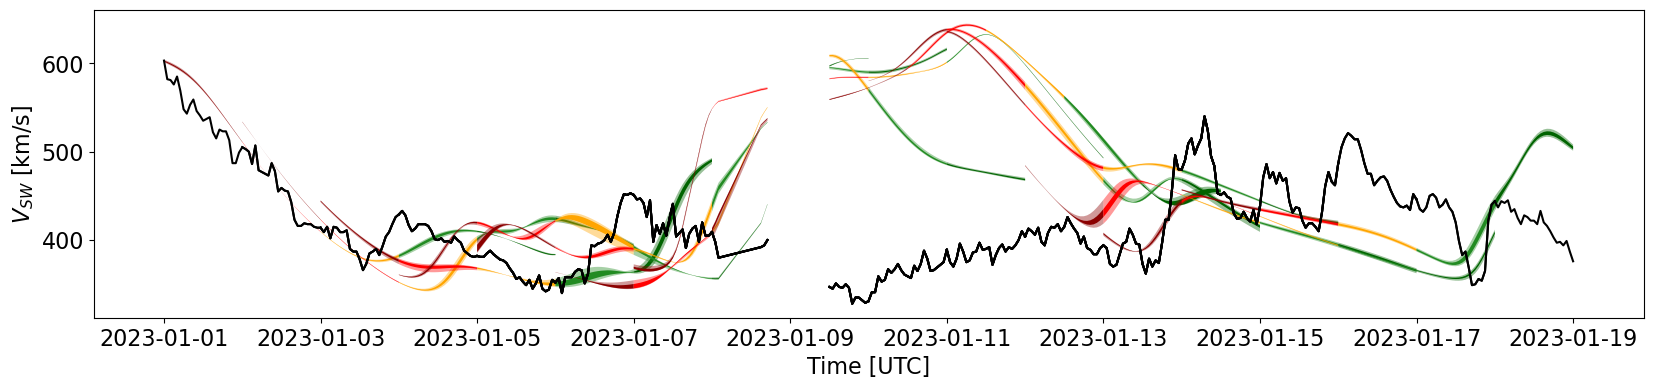

In [37]:
colors = ['darkred', 'red', 'orange', 'forestgreen', 'darkgreen', 'blue', 'cornflowerblue', 'purple', 'magenta', 'pink', 'grey']

plt.figure(figsize = (20,4))
for index in range(len(fname_list)):

    max_lead_time = 5
    for i in range(max_lead_time):

        df_ = lead_time_dict[f'{i+1}_day_lead'][index]
        df_stats = compute_lead_time_stats(df_)

        plt.fill_between(df_stats.index, df_stats['lower_2_sigma'], df_stats['upper_2_sigma'], label = r'2$\sigma$', color = colors[i], alpha = 0.4, edgecolor = None )
        plt.fill_between(df_stats.index, df_stats['lower_1_sigma'], df_stats['upper_1_sigma'], label = r'1$\sigma$', color = colors[i], alpha = 1, edgecolor = None )

        #plt.plot(df_[0])
        plt.plot(lead_time_dict[f'{i+1}_day_data'][index], color = 'black')

plt.xlabel('Time [UTC]')
plt.ylabel(r'$V_{SW}$ [km/s]')
plt.show()

(200.0, 650.0)

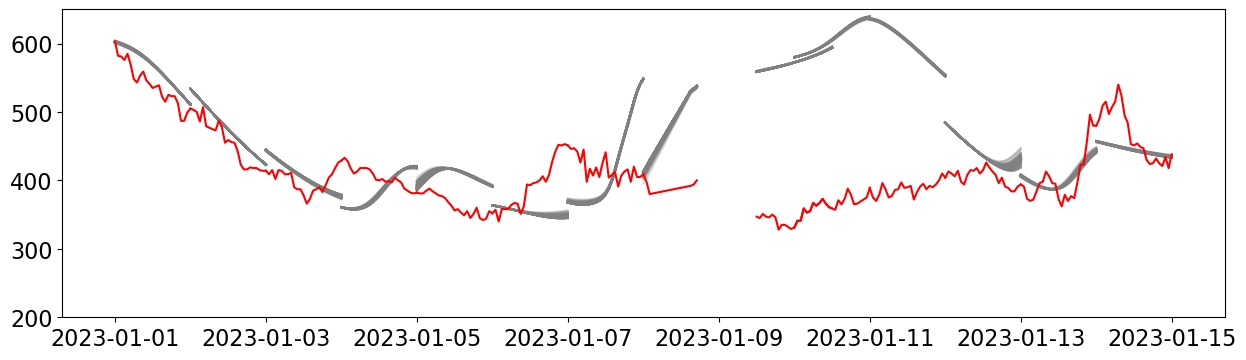

In [40]:
plt.figure(figsize = (15,4))
ensemble_size=100

for df in lead_time_dict['1_day_lead']:
    [plt.plot(df[i], color = 'grey', alpha = 0.3) for i in range(ensemble_size)]

for i, _ in enumerate(fname_list):
    plt.plot(lead_time_dict[f'1_day_data'][i], color = 'red')

plt.ylim(200,650)

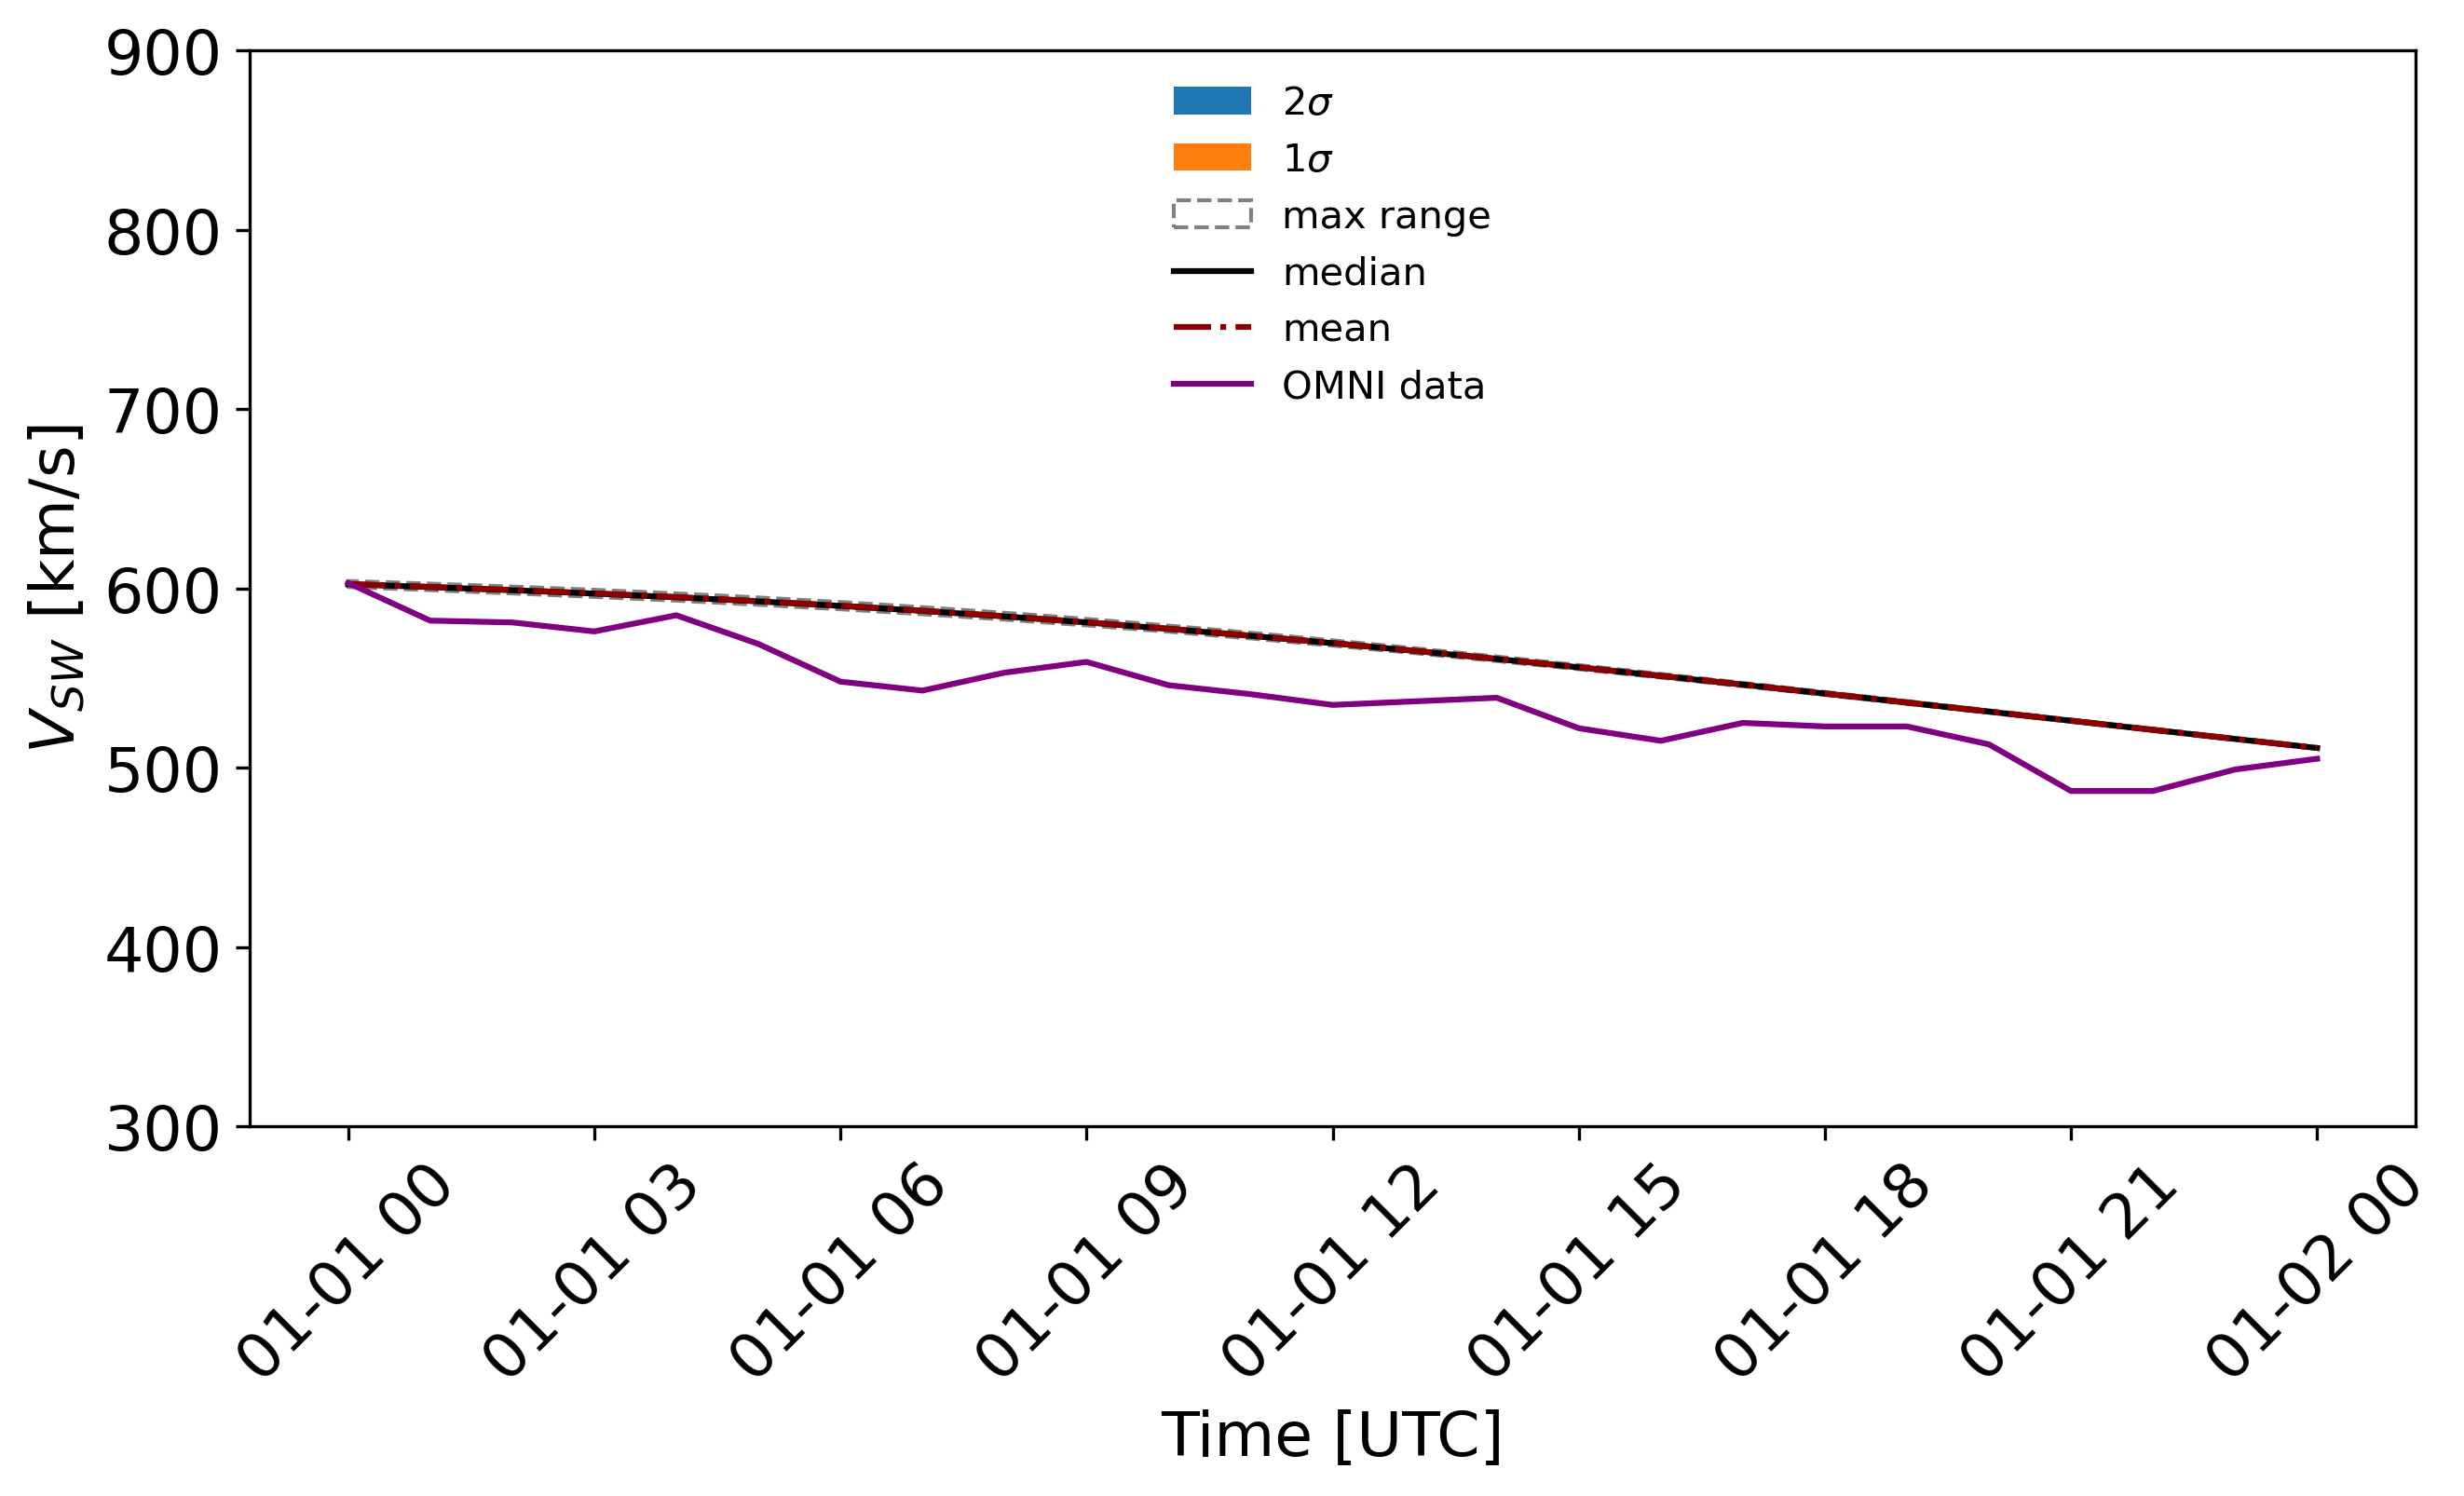

In [65]:
one_day_lead_list = [lead_time_dict['1_day_lead'][0][i] for i in range(100)]

statistics_df = hef.generate_ensemble_statistics(one_day_lead_list)
data_chunk = lead_time_dict['1_day_data'][0]

plt.figure(dpi = 300, figsize = (10,5))
plt.fill_between(statistics_df.index, statistics_df['2s_lower_percentile'], statistics_df['2s_upper_percentile'], label = r'2$\sigma$' )
plt.fill_between(statistics_df.index, statistics_df['1s_lower_percentile'], statistics_df['1s_upper_percentile'], label = r'1$\sigma$')
plt.fill_between(statistics_df.index, statistics_df['min'], statistics_df['max'], facecolor = 'none', edgecolor = 'grey', linestyle = '--', label = 'max range' )
plt.plot(statistics_df.index, statistics_df['median'], color = 'black', label = 'median')
plt.plot(statistics_df.index, statistics_df['mean'], color = 'darkred', linestyle = '-.', label = 'mean')
plt.plot(data_chunk, color = 'purple', label = 'OMNI data')
plt.legend(frameon = False, fontsize = 'medium', loc = 'upper center')
plt.xlabel('Time [UTC]')
plt.ylabel(r'$V_{SW}$ [km/s]')
plt.xticks(rotation = 45)
plt.ylim(300,900)
#plt.xlim(data_chunk.index[0], data_chunk.index[-60])
plt.show()

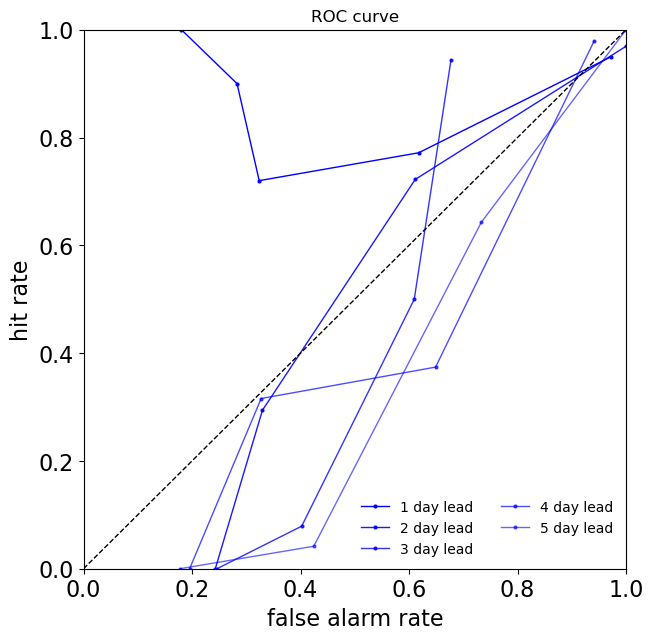

Text(0, 0.5, 'Brier Score')

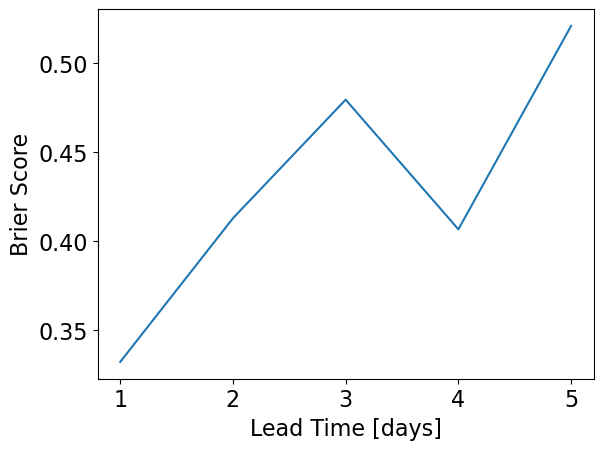

In [31]:
BS_list = []

plt.figure(figsize = (7,7))
max_lead_time = 5
for i in range(max_lead_time):
    df_combined = pd.concat(lead_time_dict[f'{i+1}_day_lead'])
    df_data = pd.concat(lead_time_dict[f'{i+1}_day_data'])

    brier_score = hef.ensemble_brier_score(ensemble_members=df_combined.to_numpy().T, observed_data=df_data.to_numpy(), event_threshold=460, ensemble_size=ensemble_size )
    roc_curve = hef.generate_roc_curve_from_ensemble(ensemble_members=df_combined.to_numpy().T, observed_data=df_data.to_numpy(), threshold_range=(300,800), threshold_num=10, probability_threshold=0.5)

    BS_list.append(brier_score)

    hit_rate, false_alarm_rate = zip(*roc_curve)

    plt.plot(false_alarm_rate, hit_rate, marker = 'o', markersize = 2, linewidth = 1, label = f'{i+1} day lead', color = 'blue', alpha = 1 - i/10)

plt.plot([0,1], [0,1], linestyle = '--', lw = 1, color = 'black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('ROC curve')
plt.xlabel('false alarm rate')
plt.ylabel('hit rate')
plt.legend(frameon= False, ncols = 2, fontsize = 'medium')
plt.show()

plt.figure()
plt.plot(np.arange(0,max_lead_time)+1, BS_list)
plt.xlabel('Lead Time [days]')
plt.ylabel('Brier Score')

In [32]:


# latitude scale parameters to evaluate
latitudes_to_test = np.linspace(0,10,11)

BS_by_lat = []

for sigma_latitude in latitudes_to_test:

    ensemble_size = 100
    sigma_longitude = 0 # degrees
    forecast_window = 10 * u.day
    r_min = 21.5*u.solRad

    max_lead_time = 5 # days
    #fname = fname_list[0]

    # params formatted as a tuple to feed to ensemble gen function
    params = ('dummy_fname', ensemble_size, sigma_latitude, forecast_window, r_min)

    lead_time_dict = split_by_lead_time(params=params, sigma_longitude=sigma_longitude, 
                                        max_lead_time=max_lead_time, observed_data=omni_data, 
                                        filenames=fname_list)
    BS_by_leadtime = []

    for i in range(max_lead_time):

        df_combined = pd.concat(lead_time_dict[f'{i+1}_day_lead'])
        df_data = pd.concat(lead_time_dict[f'{i+1}_day_data'])

        brier_score = hef.ensemble_brier_score(ensemble_members=df_combined.to_numpy().T, observed_data=df_data.to_numpy(), event_threshold=460, ensemble_size=ensemble_size)
        #roc_curve = hef.generate_roc_curve_from_ensemble(ensemble_members=df_combined.to_numpy().T, observed_data=df_data.to_numpy(), threshold_range=(300,800), threshold_num=10, probability_threshold=0.5)
        #print(f'{brier_score:.3f}')
        BS_by_leadtime.append(brier_score)

    BS_by_lat.append(BS_by_leadtime)
        #hit_rate, false_alarm_rate = zip(*roc_curve)

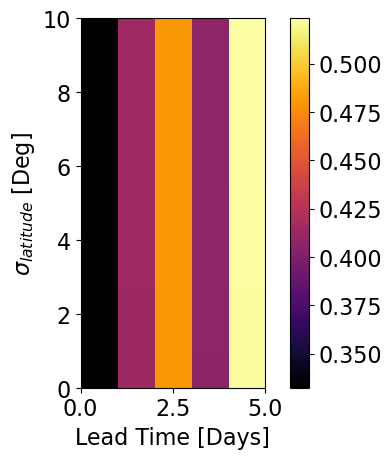

In [34]:
plt.imshow(BS_by_lat, cmap = 'inferno', extent=[0,5,0,10])
plt.xlabel('Lead Time [Days]')
plt.ylabel(r'$\sigma_{latitude}$ [Deg]')
#plt.yticks(np.linspace(0,20,6))
plt.colorbar()
plt.show()